<h1>Deep Reach</h1>

The following implementation is inspired by <h><a href="https://github.com/SimonBirrell/ppo-continuous-control">ppo-continuous-control</a></h> and <h><a href="https://github.com/higgsfield/RL-Adventure-2">RL-Adventure-2</a></h>.

<h2>Import, configure, and load reacher environment</h2>

In [1]:
# Import libaries
import math
import random
from collections import namedtuple, deque
import gym
import numpy as np

# Setup Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
print(torch.__version__)

# Setup Cuda or CPU
use_cuda = torch.cuda.is_available()
DEVICE   = torch.device("cuda" if use_cuda else "cpu")

# Start Environment
from unityagents import UnityEnvironment
env = UnityEnvironment(file_name='./unity_simulation/Reacher.x86_64')

0.4.0


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


<h2>Examine the reacher environement</h2>

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)
# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)
# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33


<h2>Hyperparameters</h2>

In [3]:
HORIZON = 275           # Range 32 to 5000
DISCOUNT_FACTOR = 0.99  # Range 0.8 to 0.9997
GAE_DISCOUNT = 0.99     # Range 0.8 to 0.9997
GAE_LAMBDA = 0.95       # Range 0.9 to 1
EPOCH_RANGE = 12        # Range 3 to 30
MINIBATCH_SIZE = 64     # Range 4 to 4096
PPO_CLIP_RANGE = 0.05    # Range 0.05 to 0.3 [testing --> 0.05; 0.1; 0.15]
LEARNING_RATE = 3e-4    # Range 0.003 to 5e-6

<h2>Utilities</h2>

In [4]:
# Following is inspired/copied from:
# https://github.com/openai/baselines/blob/master/baselines/common/running_mean_std.py    
class RunningMeanStd(object):
    def __init__(self, epsilon=1e-4, shape=()):
        self.mean = np.zeros(shape, 'float64')
        self.var = np.ones(shape, 'float64')
        self.count = epsilon

    def update(self, x):
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)
        batch_count = x.shape[0]
        self.update_from_moments(batch_mean, batch_var, batch_count)

    def update_from_moments(self, batch_mean, batch_var, batch_count):
        self.mean, self.var, self.count = update_mean_var_count_from_moments(
            self.mean, self.var, self.count, batch_mean, batch_var, batch_count)    
        
def update_mean_var_count_from_moments(mean, var, count, batch_mean, batch_var, batch_count):
    delta = batch_mean - mean
    tot_count = count + batch_count

    new_mean = mean + delta * batch_count / tot_count
    m_a = var * count
    m_b = batch_var * batch_count
    M2 = m_a + m_b + np.square(delta) * count * batch_count / tot_count
    new_var = M2 / tot_count
    new_count = tot_count

    return new_mean, new_var, new_count

def random_sample(indices, batch_size):
    indices = np.asarray(np.random.permutation(indices))
    batches = indices[:len(indices) // batch_size * batch_size].reshape(-1, batch_size)
    for batch in batches:
        yield batch
    r = len(indices) % batch_size
    if r:
        yield indices[-r:]

class MeanStdNormalizer():
    def __init__(self):
        self.rms = None
        self.clip = 10.0
        self.epsilon = 1e-8

    def __call__(self, x):
        x = np.asarray(x)
        if self.rms is None:
            self.rms = RunningMeanStd(shape=(1, ) + x.shape[1:])
        self.rms.update(x)
        return np.clip((x - self.rms.mean) / np.sqrt(self.rms.var + self.epsilon),
                       -self.clip, self.clip)

<h2>Neural Network (actor/critic)</h2>

In [5]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0., std=0.1)
        nn.init.constant_(m.bias, 0.1)
        

class ActorCritic(nn.Module):
    def __init__(self, num_agents, state_size, action_size, hidden_size, seed):
        super(ActorCritic, self).__init__()
        
        self.seed = random.seed(seed)
        
        self.critic = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size),
        )
        
        self.log_std = nn.Parameter(torch.ones(1, action_size))
        self.apply(init_weights)
        
    def forward(self, obs, action=None):
        obs = torch.tensor(obs, device=DEVICE, dtype=torch.float32)
        a = self.actor(obs)
        v = self.critic(obs)
        dist = torch.distributions.Normal(a, self.log_std.exp().expand_as(a))
        return (v, dist)

<h2>Rollout manager</h2>

In [6]:
class Rollout_manager():
    
    def __init__(self):
        # Stored data
        self.actions = []
        self.log_prob_actions = []
        self.values = []
        self.rewards = []
        self.episode_not_dones = []
        self.states = []
        
        # Calculated data
        self.returns = [0.0] * HORIZON
        self.advantages = [0.0] * HORIZON
        
    def save_prediction(self, actions, log_prob_actions, values):
        self.actions.append(actions)
        self.log_prob_actions.append(log_prob_actions)
        self.values.append(values)

    def save_consequences(self, rewards, episode_not_dones, states):
        self.rewards.append(rewards)
        self.episode_not_dones.append(episode_not_dones)
        self.states.append(states)
        
    def calculate_returns_and_advantages(self, final_reward):
        self.rewards.append(None)
        self.episode_not_dones.append(None)
        self.calculate_future_returns(final_reward)
        self.estimate_advantages()

    def calculate_future_returns(self, returns):
        for i in reversed(range(HORIZON)):
            returns = self.rewards[i] + DISCOUNT_FACTOR * self.episode_not_dones[i] * returns
            self.returns[i] = returns.detach() 

    def estimate_advantages(self):
        advantages = torch.tensor(np.zeros((num_agents, 1)), device=DEVICE, dtype=torch.float32)
        for i in reversed(range(HORIZON)):
            td = self.rewards[i] + (GAE_DISCOUNT * self.episode_not_dones[i] * self.values[i + 1]) - self.values[i]
            advantages = advantages * GAE_LAMBDA * GAE_DISCOUNT * self.episode_not_dones[i] + td
            self.advantages[i] = advantages.detach()               

    def stack_tensor(self, some_list):
        return torch.cat(some_list[:HORIZON], dim=0)
            
    def get_data(self):
        states = self.stack_tensor(self.states)
        actions = self.stack_tensor(self.actions) 
        log_prob_actions = self.stack_tensor(self.log_prob_actions)
        returns = self.stack_tensor(self.returns)
        advantages = self.stack_tensor(self.advantages)
        advantages = (advantages - advantages.mean()) / advantages.std()        
        return (states, actions, log_prob_actions, returns, advantages)

<h2>PPO algorithm</h2>

In [7]:
class PPO_algorithm():   
    
    def __init__(self, num_agents, state_size, action_size, hidden_size, seed):
        self.network = ActorCritic(num_agents, state_size, action_size, hidden_size, seed).to(DEVICE)
        self.first_states = True
        self.state_normalizer = MeanStdNormalizer()
        
    def evaluate_actions_against_states(self, states, actions):
        value, action_distribution = self.network(states, actions)
        log_prob = action_distribution.log_prob(actions).sum(-1).unsqueeze(-1)
        return (log_prob, value)
    
    def get_prediction(self, states):
        if self.first_states:
            self.states = states
            self.first_states = False
        self.latest_values, action_distribution = self.network(self.states)
        self.latest_actions = action_distribution.sample()
        self.latest_log_prob = action_distribution.log_prob(self.latest_actions).sum(-1).unsqueeze(-1)
        return self.latest_actions
    
    def step(self, states, actions, rewards, next_states, dones):
        rewards = np.asarray(rewards)
        next_states = self.state_normalizer(next_states)
        self.rollout.save_prediction(self.latest_actions, self.latest_log_prob, self.latest_values)
        dones = np.asarray(dones).astype(int)
        rewards = torch.tensor(rewards, device=DEVICE, dtype=torch.float32).unsqueeze(-1)
        episode_not_dones = torch.tensor((1 - dones), device=DEVICE, dtype=torch.float32).unsqueeze(-1)
        states = torch.tensor(self.states, device=DEVICE, dtype=torch.float32)      
        self.rollout.save_consequences(rewards, episode_not_dones, states)
        self.states = next_states
                
    def create_rollout(self):
        self.rollout = Rollout_manager()
            
    def process_rollout(self, states):
        # save final results
        self.get_prediction(states)
        self.rollout.save_prediction(self.latest_actions, self.latest_log_prob, self.latest_values)
        # Calculate resutns and advantages
        self.rollout.calculate_returns_and_advantages(self.latest_values.detach())
        # Optimize
        self.optimize()
        self.first_states = True
   
    def save_weights(self):
        torch.save(self.network.state_dict(), "trained_weights.pth")
        print("Weights are saved to trained_weights.pth")
        
    def ppo_update(self, optimizer, sampled_states, sampled_actions, sampled_log_probs_old, sampled_returns, sampled_advantages):
        log_prob_action, value = self.evaluate_actions_against_states(sampled_states, sampled_actions)
        
        # Policy Loss
        ratio = (log_prob_action - sampled_log_probs_old).exp() 
        obj = ratio * sampled_advantages
        obj_clipped = ratio.clamp(1.0 - PPO_CLIP_RANGE, 1.0 + PPO_CLIP_RANGE) * sampled_advantages
        policy_loss = -torch.min(obj, obj_clipped).mean() 
        
        # Value Loss
        value_loss = 0.5 * (sampled_returns - value).pow(2).mean()
        
        # Optimize network weights
        loss = policy_loss + value_loss
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.network.parameters(), 0.75) 
        optimizer.step()

    def optimize(self):
        states, actions, log_probs_old, returns, advantages = self.rollout.get_data()
        actions = actions.detach()
        log_probs_old = log_probs_old.detach()
        optimizer = torch.optim.Adam(self.network.parameters(), LEARNING_RATE, eps=1e-5)
        for i in range(EPOCH_RANGE):
            number_timesteps = states.size(0)
            timesteps_to_sample = random_sample(np.arange(number_timesteps), MINIBATCH_SIZE) 
            for timestep in timesteps_to_sample:
                t = torch.tensor(timestep, device=DEVICE, dtype=torch.float32).long()
                sampled_states = states[t]
                sampled_actions = actions[t]
                sampled_log_probs_old = log_probs_old[t]
                sampled_returns = returns[t]
                sampled_advantages = advantages[t]
                self.ppo_update(optimizer, sampled_states, sampled_actions, sampled_log_probs_old, sampled_returns, sampled_advantages)

<h1>Train agent</h1>

In [8]:
class train_agent():
    
    def __init__(self, num_workers):
        self.num_workers = num_workers
        self.online_rewards = np.zeros(num_workers)
        self.running_mean_score = 0
        self.mean_scores = []
                
    def train_ppo(self, agent, target_avg_score, max_episodes=300, train_mode_=True):
        if train_mode_:
            print("========================================================================================")
            print("Beginning training...")
            print("GOAL: Mean episode score of {:.2f} over the last 100 episodes in less than {} episodes.".format(target_avg_score, max_episodes))
            print("========================================================================================")
        else:
            print("Testing Agent")
        
        # Reset environment:
        env_info = env.reset(train_mode=train_mode_)[brain_name]
        
        # Initialize variables:
        self.num_episodes = 0
        self.last_100_scores = deque(maxlen=100)
        self.episode_scores = [list() for i in range(num_agents)]
        self.episodes_finished = 0
        self.target_avg_score = target_avg_score
        
        while True:
            # Run a rollout (max HORIZON)
            states = env_info.vector_observations # Get current states
            scores = np.zeros(num_agents) # Initialize scores list
            agent.create_rollout() # Create rollout instance
            
            horizon_ = HORIZON

            for t in range(horizon_):
                # Get actions from policy
                actions = np.clip(agent.get_prediction(states).cpu().detach().numpy(), -1, 1) # Limit max torque between -1 and 1

                # Use the actions in the environemnt and get next state
                env_info = env.step(actions)[brain_name]
                next_states = env_info.vector_observations
                rewards = env_info.rewards
                dones = env_info.local_done

                # Save rewards
                self.online_rewards += rewards
                for i, done in enumerate(dones):
                    # If a worker is done end the episode for this worker
                    if done:
                        # Save the workers reward from the episode
                        self.episode_scores[i].append(self.online_rewards[i])   
                        self.episodes_finished +=1
                        # If all workers finished end the entire episode
                        if (self.episodes_finished % num_agents) == 0:
                            self.num_episodes += 1
                            total_score = 0
                            for j in range(num_agents):
                                total_score += self.episode_scores[j][-1]
                            mean_score = total_score / num_agents    
                            self.last_100_scores.append(mean_score)
                            self.mean_scores.append(mean_score)
                            if train_mode_:
                                print("Episode: %3.0f | Mean episode score: %7.4f | Mean 100 episode score: %7.4f" % (self.num_episodes, round(mean_score, 6), round(np.mean(self.last_100_scores),6)))

                        # Set accumulated reward to zero for next episode
                        self.online_rewards[i] = 0
                        # Calculate running mean
                        self.running_mean_score = np.mean(self.last_100_scores)
                        # Break if the target if reached 
                        if self.running_mean_score > self.target_avg_score and train_mode_:
                            print(" ")
                            print("*** Target reached! ***")
                            print(" ")
                            break

                agent.step(states, actions, rewards, next_states, dones) 
                scores += rewards
                states = next_states
                
            # Optimize the agent using PPO and the data from the last rollout
            agent.process_rollout(states)

            # Check exit conditions
            if self.running_mean_score > target_avg_score and train_mode_:
                print("Mean episode score of %s over the last 100 episodes" % self.running_mean_score)
                agent.save_weights() 
                break
            if self.num_episodes > max_episodes and train_mode_:
                print("Failed mean episode score of {:.2f} over the 100 most recent episodes in less than {} episodes.".format(target_avg_score, self.num_episodes))
                agent.save_weights() 
                break
        return self.mean_scores           

<h1> Train PPO agent </h1>

In [9]:
from numpy import savetxt
import warnings
warnings.filterwarnings('ignore') # ignore Rimtime Warnings

scores        = []
for i in range(1):
    agent         = PPO_algorithm(num_agents, state_size=state_size, action_size=action_size, hidden_size=32, seed=123)
    train_session = train_agent(num_agents)
    scores.append(train_session.train_ppo(agent, 99.0, 300))
    
# Save scores to csv file:
episodes = []
scores_con = []
for i in range(len(scores)):
    episodes += range(len(scores[i]))
    scores_con += scores[i]
    
savetxt('./score.csv', np.c_[episodes,scores_con], delimiter=",")

Beginning training...
GOAL: Mean episode score of 99.00 over the last 100 episodes in less than 300 episodes.
Episode:   1 | Mean episode score:  0.1860 | Mean 100 episode score:  0.1860
Episode:   2 | Mean episode score:  0.1310 | Mean 100 episode score:  0.1585
Episode:   3 | Mean episode score:  0.1260 | Mean 100 episode score:  0.1477
Episode:   4 | Mean episode score:  0.1355 | Mean 100 episode score:  0.1446
Episode:   5 | Mean episode score:  0.1375 | Mean 100 episode score:  0.1432
Episode:   6 | Mean episode score:  0.2605 | Mean 100 episode score:  0.1628
Episode:   7 | Mean episode score:  0.1610 | Mean 100 episode score:  0.1625
Episode:   8 | Mean episode score:  0.2290 | Mean 100 episode score:  0.1708
Episode:   9 | Mean episode score:  0.3075 | Mean 100 episode score:  0.1860
Episode:  10 | Mean episode score:  0.2925 | Mean 100 episode score:  0.1966
Episode:  11 | Mean episode score:  0.3430 | Mean 100 episode score:  0.2100
Episode:  12 | Mean episode score:  0.5915 

Episode: 104 | Mean episode score: 17.4110 | Mean 100 episode score:  4.2712
Episode: 105 | Mean episode score: 16.0520 | Mean 100 episode score:  4.4303
Episode: 106 | Mean episode score: 17.5025 | Mean 100 episode score:  4.6027
Episode: 107 | Mean episode score: 18.8800 | Mean 100 episode score:  4.7899
Episode: 108 | Mean episode score: 17.2845 | Mean 100 episode score:  4.9605
Episode: 109 | Mean episode score: 19.7480 | Mean 100 episode score:  5.1549
Episode: 110 | Mean episode score: 21.8560 | Mean 100 episode score:  5.3705
Episode: 111 | Mean episode score: 19.2635 | Mean 100 episode score:  5.5597
Episode: 112 | Mean episode score: 19.9305 | Mean 100 episode score:  5.7531
Episode: 113 | Mean episode score: 20.5075 | Mean 100 episode score:  5.9512
Episode: 114 | Mean episode score: 21.8005 | Mean 100 episode score:  6.1639
Episode: 115 | Mean episode score: 19.6760 | Mean 100 episode score:  6.3520
Episode: 116 | Mean episode score: 22.5950 | Mean 100 episode score:  6.5707

Episode: 211 | Mean episode score: 37.0545 | Mean 100 episode score: 33.3919
Episode: 212 | Mean episode score: 38.0730 | Mean 100 episode score: 33.5733
Episode: 213 | Mean episode score: 37.7710 | Mean 100 episode score: 33.7459
Episode: 214 | Mean episode score: 37.0045 | Mean 100 episode score: 33.8980
Episode: 215 | Mean episode score: 37.3785 | Mean 100 episode score: 34.0750
Episode: 216 | Mean episode score: 37.9760 | Mean 100 episode score: 34.2288
Episode: 217 | Mean episode score: 37.6780 | Mean 100 episode score: 34.3689
Episode: 218 | Mean episode score: 38.4185 | Mean 100 episode score: 34.5230
Episode: 219 | Mean episode score: 38.1755 | Mean 100 episode score: 34.6536
Episode: 220 | Mean episode score: 37.6740 | Mean 100 episode score: 34.7881
Episode: 221 | Mean episode score: 38.0240 | Mean 100 episode score: 34.9207
Episode: 222 | Mean episode score: 36.9765 | Mean 100 episode score: 35.0381
Episode: 223 | Mean episode score: 38.1970 | Mean 100 episode score: 35.1535

<h1> Plot score </h1>

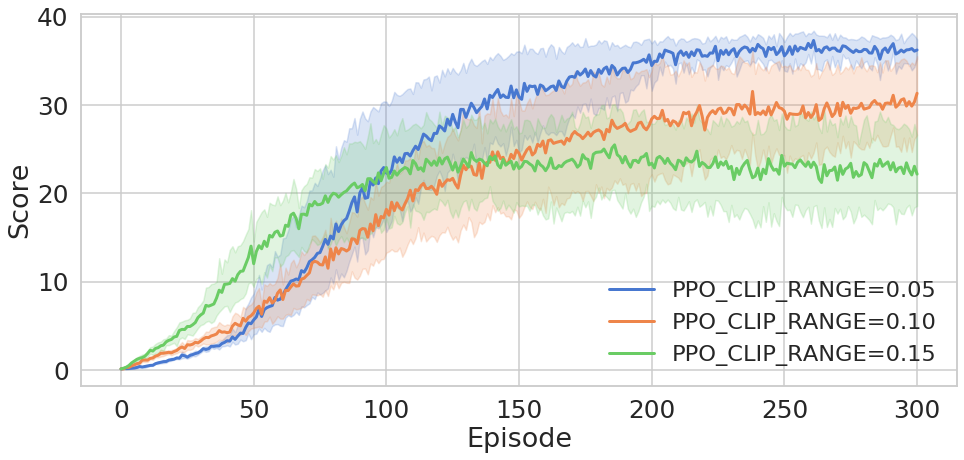

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
sns.set()

# Setup seaborn for plotting
sns.set("talk", font_scale=1.5,  rc={"lines.linewidth": 3, 'figure.figsize': (14, 7)})
sns.set_palette("muted")
sns.set_style("whitegrid")
 
# Get and arrange data
df05 = pd.read_csv("./data/score_0_05.csv")      # Read CSV file generated while training
df05.columns = ["episodes", "scores"]  # Rename columns 
df1 = pd.read_csv("./data/score_0_1.csv")      # Read CSV file generated while training
df1.columns = ["episodes", "scores"]  # Rename columns 
df15 = pd.read_csv("./data/score_0_15.csv")      # Read CSV file generated while training
df15.columns = ["episodes", "scores"]  # Rename columns 

# Plot data
sns_plot = sns.lineplot('episodes', 'scores', data=df05)
sns_plot = sns.lineplot('episodes', 'scores', data=df1)
sns_plot = sns.lineplot('episodes', 'scores', data=df15)
sns_plot.set(ylabel='Score', xlabel='Episode')
sns_plot.legend(fontsize = 'small', loc='lower right', labels=["PPO_CLIP_RANGE=0.05", "PPO_CLIP_RANGE=0.10", "PPO_CLIP_RANGE=0.15"], framealpha = 0)
figure = sns_plot.get_figure()
figure.tight_layout()
figure.savefig('./score_episode.png', dpi=200) # Save figure to score.png
plt.show()

<h1> Load and test trained agent </h1>

In [10]:
agent         = PPO_algorithm(num_agents, state_size=state_size, action_size=action_size, hidden_size=32, seed=123)
agent.network.load_state_dict(torch.load('./saved_models/trained_weights.pth'))
train_session = train_agent(num_agents)
train_session.train_ppo(agent, 99.0, 300, False)

Testing Agent


KeyboardInterrupt: 